In [35]:
import torch
from torch.utils.data import DataLoader, random_split, TensorDataset
from ConvAutoencoder import Autoencoder
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [26]:
# Carica il dataset
dataset_path = '/Users/edoardozappia/Desktop/Tesi_Magistrale/frames_sinus.pt'  # Percorso del file .pt
frames = torch.load(dataset_path)

# Dimensioni del dataset
dataset_size = len(frames)
train_size = int(0.8 * dataset_size)  # 80% per il training
val_size = dataset_size - train_size  # 20% per la validazione

# Shuffle e divisione del dataset
dataset = TensorDataset(frames)  # Crea un dataset PyTorch
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Creazione dei DataLoader
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Stampa informazioni
print(f"Dimensione dataset: {dataset_size}")
print(f"Dimensione training set: {train_size}")
print(f"Dimensione validation set: {val_size}")


Dimensione dataset: 34650
Dimensione training set: 27720
Dimensione validation set: 6930


In [27]:
autoencoder = Autoencoder()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()
num_epochs = 10
losses = []

In [28]:
for epoch in range(num_epochs):
    autoencoder.train()
    train_loss = 0
    for batch in train_loader:
        images = batch[0]
        images = images.float() / 255.0  # Conversione e normalizzazione
        images = images.permute(0, 3, 1, 2)  # Cambia la forma in (batch_size, channels, height, width)
        optimizer.zero_grad()
        reconstructed = autoencoder(images)
        loss = criterion(reconstructed, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    losses.append(train_loss)  # Salva la perdita per il grafico
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}")

Epoch 1/10, Loss: 0.0020
Epoch 2/10, Loss: 0.0003
Epoch 3/10, Loss: 0.0002
Epoch 4/10, Loss: 0.0001
Epoch 5/10, Loss: 0.0001
Epoch 6/10, Loss: 0.0001
Epoch 7/10, Loss: 0.0001
Epoch 8/10, Loss: 0.0001
Epoch 9/10, Loss: 0.0001
Epoch 10/10, Loss: 0.0001


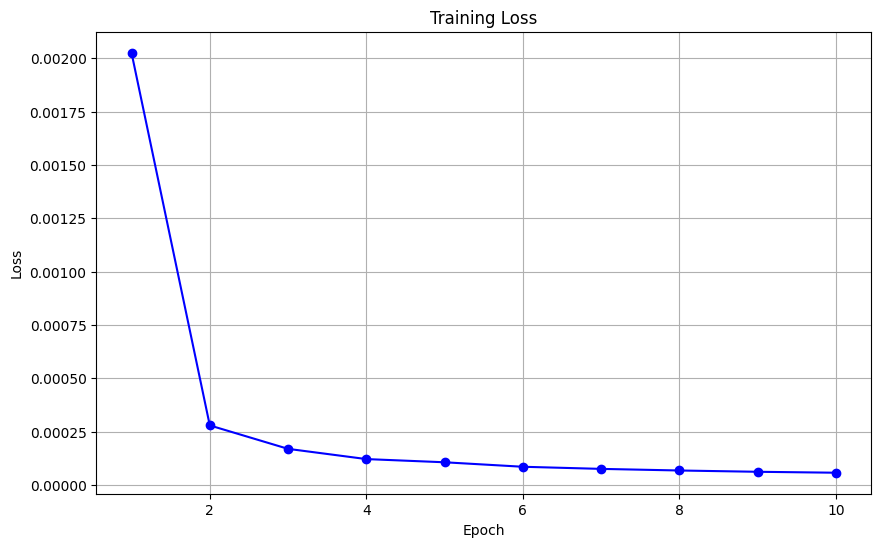

In [29]:
# Tracciamento del grafico della loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [39]:
autoencoder.eval()

# Test del modello
errors = []
with torch.no_grad():  # Disabilita il calcolo del gradiente
    for batch in val_loader:
        images = batch[0]
        images = images.float() / 255.0  # Normalizza le immagini
        images = images.permute(0, 3, 1, 2)  # Cambia l'ordine delle dimensioni
        reconstructed = autoencoder(images)  # Ricostruzione
        
        # Calcola l'errore (ad esempio, MSE per immagine)
        batch_errors = F.mse_loss(reconstructed, images, reduction='none')
        batch_errors = batch_errors.mean(dim=[1, 2, 3]).cpu().numpy()  # Media per immagine
        errors.extend(batch_errors)
        #break  # Testa solo un batch per visualizzazione

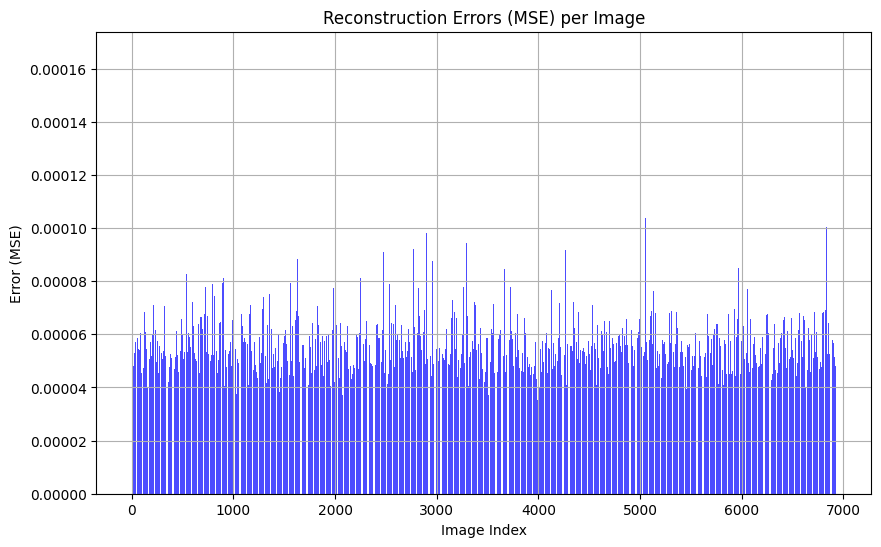

In [40]:
# Plotta l'errore
plt.figure(figsize=(10, 6))
plt.bar(range(len(errors)), errors, color='b', alpha=0.7)
plt.title("Reconstruction Errors (MSE) per Image")
plt.xlabel("Image Index")
plt.ylabel("Error (MSE)")
plt.grid(True)
plt.show()

In [31]:
# Converti in NumPy per la visualizzazione
original_images = images.permute(0, 2, 3, 1).cpu().numpy()  # Da (N, C, H, W) a (N, H, W, C)
reconstructed_images = reconstructed.permute(0, 2, 3, 1).cpu().numpy()

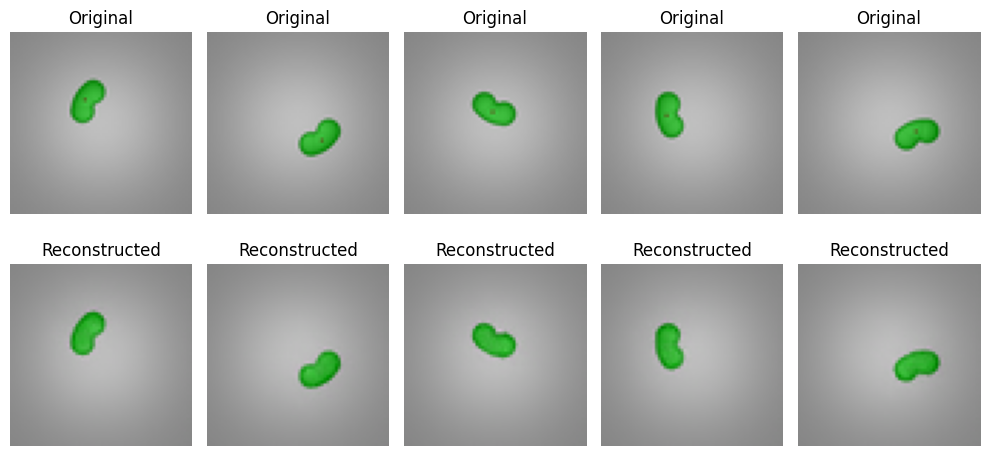

In [32]:
# Visualizza alcune immagini originali e ricostruite
num_images = 5
plt.figure(figsize=(10, 5))
for i in range(num_images):
    # Immagine originale
    plt.subplot(2, num_images, i + 1)
    plt.imshow(original_images[i])
    plt.title("Original")
    plt.axis('off')
    
    # Immagine ricostruita
    plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(reconstructed_images[i])
    plt.title("Reconstructed")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [41]:
# Salva il modello dell'encoder
torch.save(autoencoder.encoder.state_dict(), 'encoder.pth')

In [42]:
# Salva il modello del decoder
torch.save(autoencoder.decoder.state_dict(), 'decoder.pth')